In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tqdm import tqdm

In [2]:
def build_model(pretrained):
    model = Sequential([
        pretrained,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [3]:
base_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)


Found 100000 images belonging to 2 classes.


In [4]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [5]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [6]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit(
    train_flow,
    epochs = 5,
    steps_per_epoch =train_steps,
    validation_data =valid_flow,
    validation_steps = valid_steps
)

Epoch 1/5
1562/1562 [==============================] - 1067s 672ms/step - loss: 0.6352 - accuracy: 0.6344 - val_loss: 0.7395 - val_accuracy: 0.6868
Epoch 2/5
1562/1562 [==============================] - 632s 405ms/step - loss: 0.3618 - accuracy: 0.8416 - val_loss: 0.3498 - val_accuracy: 0.8465
Epoch 3/5
1562/1562 [==============================] - 636s 407ms/step - loss: 0.2113 - accuracy: 0.9136 - val_loss: 0.2341 - val_accuracy: 0.9079
Epoch 4/5
1562/1562 [==============================] - 635s 407ms/step - loss: 0.1310 - accuracy: 0.9496 - val_loss: 0.2588 - val_accuracy: 0.8944
Epoch 5/5
1562/1562 [==============================] - 635s 406ms/step - loss: 0.0832 - accuracy: 0.9680 - val_loss: 0.4332 - val_accuracy: 0.8433


In [7]:
model.save('completed_trained_model.h5')

In [8]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

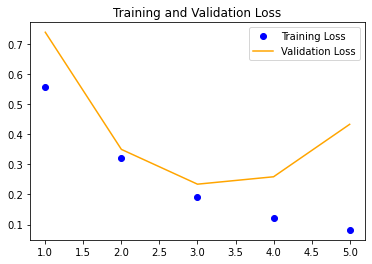

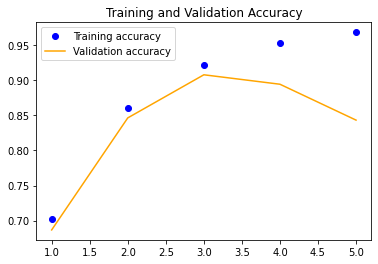

In [10]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [11]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred = model.predict(test_flow)
y_test = test_flow.classes

Found 20000 images belonging to 2 classes.


In [12]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.971000345
AP Score: 0.9681545693080338

              precision    recall  f1-score   support

           0       0.99      0.70      0.82     10000
           1       0.77      0.99      0.86     10000

    accuracy                           0.84     20000
   macro avg       0.88      0.84      0.84     20000
weighted avg       0.88      0.84      0.84     20000

